In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import enum
import os

import sys
# sys.path.append( '/content/drive/My Drive/thesis-workspace' ) # drive version
sys.path.append( '../../src/' ) # local version

from ml.preprocessing import *
from ml.constants import *

# Loading and generating datasets

In [3]:
# path = [ '.', 'drive', 'My Drive', 'thesis-workspace', 'datasets' ]
path = [ '..', '..', 'datasets', 'resolutions' ]
out_path = [ '..', '..', 'datasets', 'feature_selection' ]

df = pd.read_csv( os.path.join( *path, 'gym-1sec.csv' ) , index_col = 'date', parse_dates = [ 'date' ] ).drop( columns = [ 'alt' ] )

In [4]:
class DF( enum.Enum ):
    _FULL = 1
    _REDUCED_RFE = 2
    _REDUCED_KBEST = 2
    _MIN = 3

dfs = { DF._FULL: None, DF._REDUCED_RFE: None, DF._REDUCED_KBEST: None, DF._MIN: None }

# adding seconds resolution to time index

df = df.reset_index()
df[ 'seconds' ] = df.groupby( pd.Grouper( key = 'date', freq = 'min' ) ).cumcount()
df[ 'date' ] = df.date + pd.to_timedelta( df.seconds, unit = 's' )
df = df.drop( columns = [ 'seconds' ] ).set_index( 'date' )

In [5]:
%%time

# Minimal features dataset

dfs[ DF._MIN ] = resample_df( df, '10s' )
dfs[ DF._MIN ].to_csv( os.path.join( *out_path, 'ds-gym-fs-min.csv' ) )

CPU times: user 269 ms, sys: 108 ms, total: 377 ms
Wall time: 376 ms


In [6]:
%%time

# Extended features dataset

agg = [ 'mean', 'std', pd.DataFrame.kurt ]
dfs[ DF._FULL ] = ( df.resample( '10s' )
     .agg( { 'pre': agg, 'hum': agg, 'tem': agg, 'occ': mode, } )
     .dropna( axis = 0, how = 'any' ) )

CPU times: user 10min 52s, sys: 4.8 s, total: 10min 57s
Wall time: 10min 55s


In [8]:
dfs[ DF._FULL ].columns = [ c[ 0 ] + '_' + c[ 1 ] for c in dfs[ DF._FULL ].columns ]
dfs[ DF._FULL ] = dfs[ DF._FULL ].rename( columns = { 'occ_mode': 'occ' } )
dfs[ DF._FULL ].to_csv( os.path.join( *out_path, 'ds-gym-fs-full.csv' ) )

# We will need the reference after splitting

df_full = dfs[ DF._FULL ]

# Normalizing and Balancing

In [10]:
from imblearn.over_sampling import ADASYN
from collections import Counter

# Number of neighbors to use for balancing each dataset

neighbors = { 
    DF._FULL: 1,
    DF._REDUCED_RFE: 1,
    DF._REDUCED_KBEST: 1,
    DF._MIN: 1
}

for k, d in dfs.items() :  
    if( k != DF._REDUCED_RFE and k != DF._REDUCED_KBEST ): 
        temp = list( split_data( d, test_size = 0.20 ) )
        temp[ X_TRAIN ], temp[ X_TEST ] = standardize( temp[ X_TRAIN ], temp[ X_TEST ] )

        print( 'Before balancing:', k, Counter( temp[ Y_TRAIN ] ) )
        temp[ X_TRAIN ], temp[ Y_TRAIN ] = balance_df( 
            temp[ X_TRAIN ], 
            temp[ Y_TRAIN ], 
            neighbors[ k ] )
        print( 'After balancing:', k, Counter( temp[ Y_TRAIN ] ) )
        print()

        dfs[ k ] = temp

Before balancing: DF._FULL Counter({'M': 438, 'L': 195, 'H': 184})
After balancing: DF._FULL Counter({'H': 448, 'M': 438, 'L': 435})

Before balancing: DF._MIN Counter({'M': 434, 'L': 198, 'H': 189})
After balancing: DF._MIN Counter({'L': 434, 'M': 434, 'H': 434})



# Features Selection

In [11]:
from ml.feature_selection import *

## Recursive Feature Elimination 

In [12]:
x_train, x_test, y_train, y_test = dfs[ DF._FULL ]

selected_rfe = select_k_rfe( x_train, y_train, df_full.columns[ : -1 ], 5 )
selected_rfe

,rank,selected
pre_mean,1,1
hum_mean,1,1
tem_mean,1,1
tem_std,1,1
tem_kurt,1,1
hum_kurt,2,0
hum_std,3,0
pre_kurt,4,0
pre_std,5,0


In [13]:
dfs[ DF._REDUCED_RFE ] = df_full.drop( columns = selected_rfe.index[ 5: ] )
dfs[ DF._REDUCED_RFE ].to_csv( os.path.join( *out_path, 'ds-gym-fs-rfe.csv' ) )

## 3.2 Selecting K-best

In [14]:
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions( precision = 2 )

selected_kbest = select_k_best( x_train, y_train, df_full.columns[ : -1 ], 'all' )
selected_kbest

,score,p-value
pre_mean,105.29,0.00
hum_mean,102.77,0.00
tem_mean,97.42,0.00
pre_std,49.79,0.00
tem_kurt,22.76,0.00
pre_kurt,11.46,0.00
hum_std,10.37,0.00
tem_std,4.31,0.01
hum_kurt,3.72,0.02


In [15]:
dfs[ DF._REDUCED_KBEST ] = df_full.drop( columns = selected_kbest.index[ 5: ] )
dfs[ DF._REDUCED_RFE ].to_csv( os.path.join( *out_path, 'ds-gym-fs-kbest.csv' ) )

## 3.3 Feature Correlation

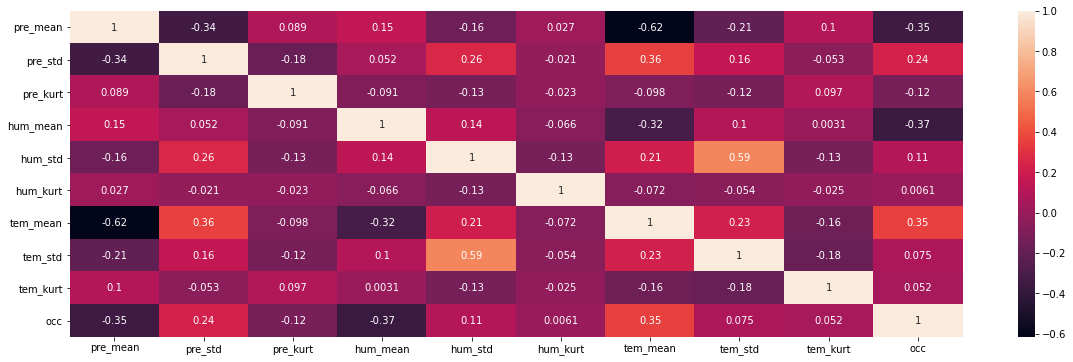

In [16]:
temp = np.concatenate( ( x_train, y_train.replace( { 'E': 0, 'L':1, 'M':2, 'H':3 } ).values.reshape( len( y_train ), 1 ) ), axis = 1 )
temp = pd.DataFrame( data = temp, columns = df_full.columns )

plt.subplots( 1, 1, figsize = ( 20, 6 ) )
sns.heatmap( temp.corr(), annot = True )